## Data Collection and Loading

In [116]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Read the data
X_full = pd.read_csv(r'C:\Users\user\Documents\GitRepository\HousePrices-AdvancedRegressionTechniques\Received\train.csv')
X_full.set_index('Id',inplace = True)

## EDA

In [3]:
# Check for abnormality to determine if data cleaning is needed
print(X_full.sample(10))
print(X_full.describe())
print(X_full.info())

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
316           60       RL         71.0     7795   Pave   NaN      IR1   
609           70       RL         78.0    12168   Pave   NaN      Reg   
1031         190       RH          NaN     7082   Pave   NaN      Reg   
686          160       RL          NaN     5062   Pave   NaN      IR1   
977           30       RL         51.0     5900   Pave   NaN      IR1   
1133          70       RM         90.0     9900   Pave   NaN      Reg   
343           90       RL          NaN     8544   Pave   NaN      Reg   
1437          20       RL         60.0     9000   Pave   NaN      Reg   
1391          20       RL         70.0     9100   Pave   NaN      Reg   
1125          80       RL          NaN     9125   Pave   NaN      IR1   

     LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                    ...   

<Axes: xlabel='SalePrice', ylabel='Count'>

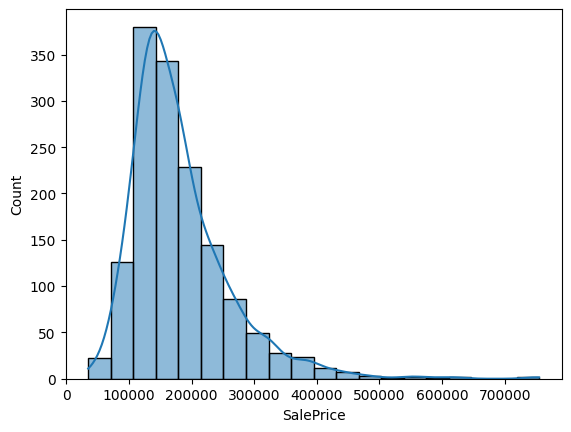

In [4]:
# Visualize the data to see data correlation 
import seaborn as sns
# Create histogram for target sales price
sns.histplot(X_full['SalePrice'], kde=True, bins=20)

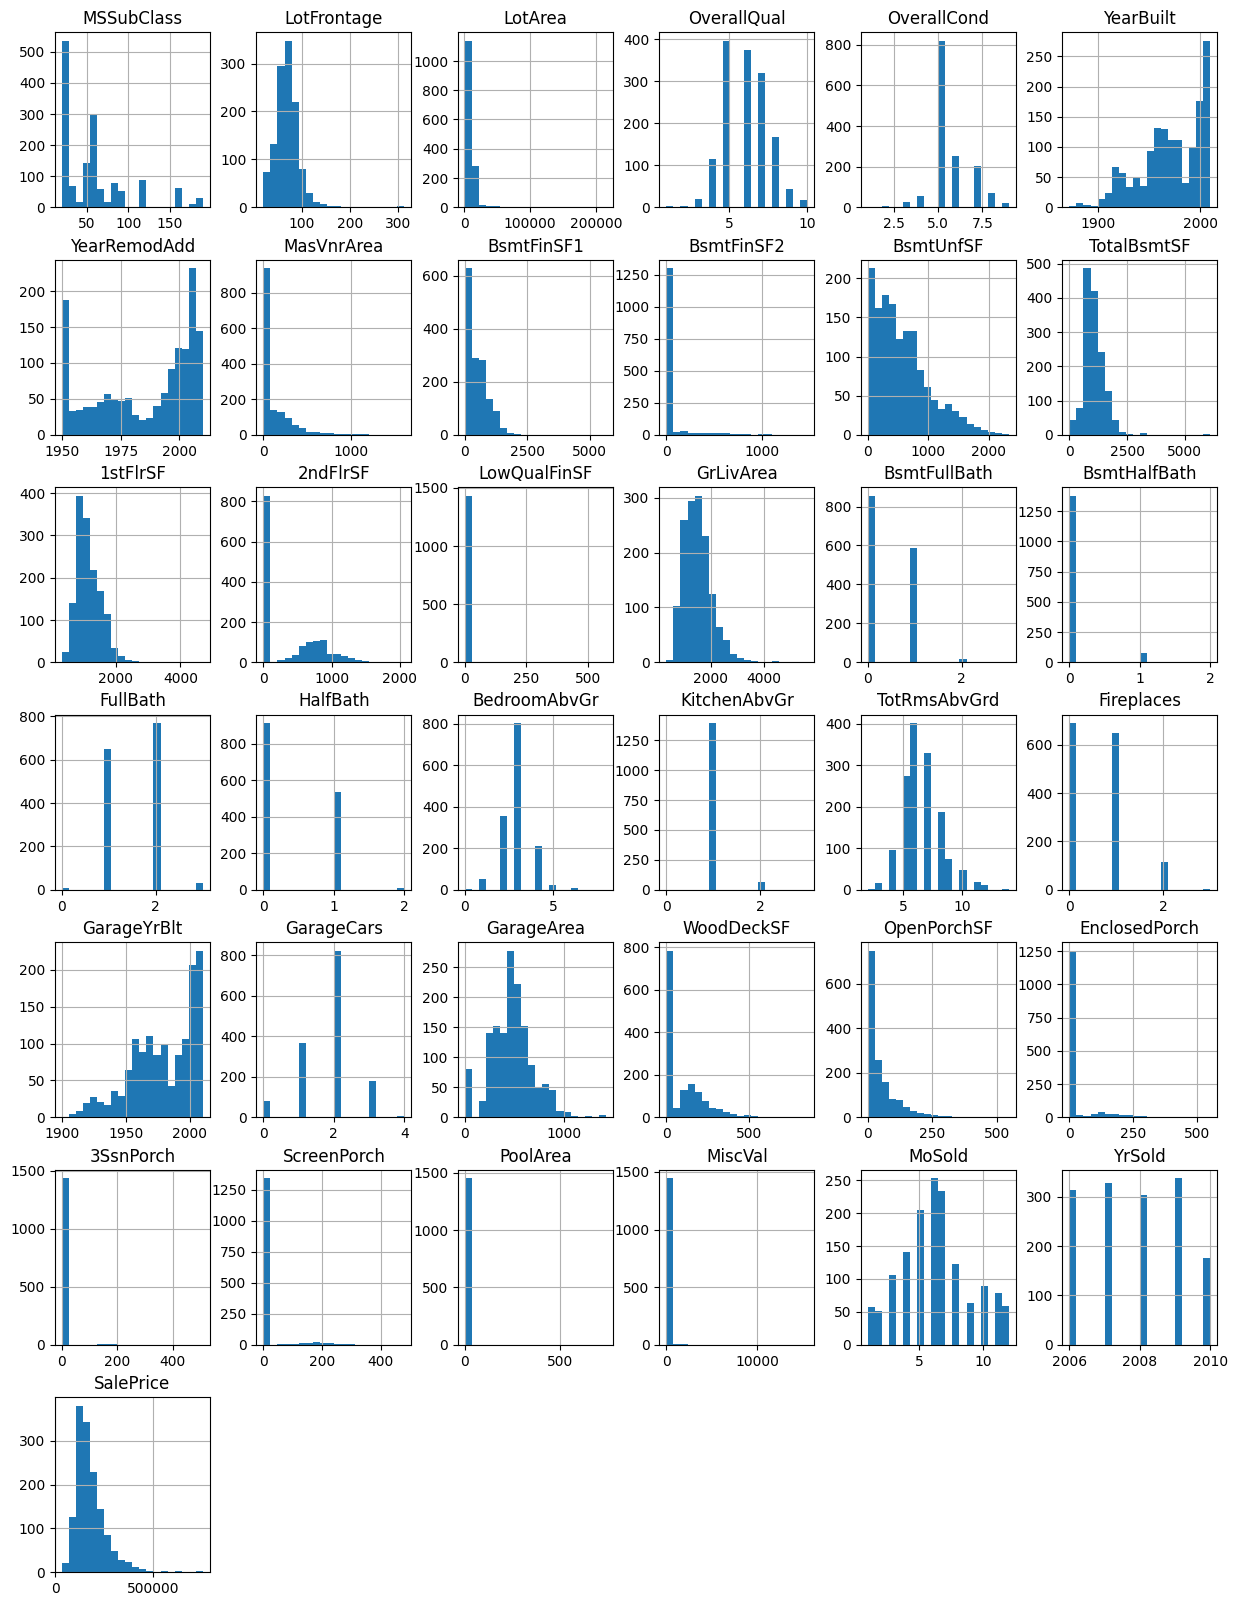

In [5]:
# Create histogram to visualize all relevant data
import matplotlib.pyplot as plt
X_full.hist(bins = 20, figsize = [15,20])
plt.show()

In [6]:
# Check for NaN values exist in data
missing_value = X_full.isna().mean()
print(missing_value[missing_value>0] * 100)
print(missing_value[missing_value>0].index)
# missing_percentage = missing_value[missing_value>0]/len(X_full) * 100
# print(missing_percentage)

LotFrontage     17.739726
Alley           93.767123
MasVnrType      59.726027
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64
Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


## Data Preprocessing

In [7]:
# Based on the given training data, there are some of the columns that have NaN values
# However, majority are less than 20%, hence will create a custom transformer to remove columns that have more than 20% of NaN values
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

class DropHighMissingValTransformer (BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self.threshold = threshold
        self.columns_to_drop = None
    
    def fit(self, X, y = None):
        if isinstance(X, pd.DataFrame) == False:
            X = pd.DataFrame(X)
            
        print(f"Inside fit, X shape: {X.shape}") 
        # Remember the column where the NaN val is larger than threshold
        missing_val = X.isna().mean()
        column_to_drop = missing_val[missing_val > self.threshold].index
        self.columns_to_drop = column_to_drop
        print(f"Columns to drop: {column_to_drop}") 
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame) == False:
            X = pd.DataFrame(X)
            
        # Return the data excluding the columns to drop
        print(f'Dropping column {self.columns_to_drop}')
        if self.columns_to_drop is not None:
            X = X.drop(columns = self.columns_to_drop, errors = 'ignore')
        return X

# Just testing out to see if it works
transformer = DropHighMissingValTransformer(threshold = 0.5)
transformer.fit(X_full)
testing = transformer.transform(X_full)
print(testing.columns)

Inside fit, X shape: (1460, 80)
Columns to drop: Index(['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')
Dropping column Index(['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')
Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQ

In [53]:
# Split into features and label
X = X_full.drop('SalePrice', axis= 1)
y = X_full['SalePrice']

# Split the data into training and validation data
X_train, X_validation, y_train, y_validation = train_test_split(X,y,test_size = 0.2, random_state = 0)

# Remember the index for each input data:
X_train_index, X_validation_index =X_train.index, X_validation.index

# Create pipeline to remove high NaN value columns:
drop_nan_pipeline = Pipeline(steps = [('drop_nan',DropHighMissingValTransformer(threshold = 0.2))])

# Here define the data preprocessing pipeline:
# Grab all numerical and categorical features:
numerical_features = X.select_dtypes(include = 'number').columns
categorical_features = X.select_dtypes(include = 'object').columns

# Create preprocessing pipeline for numeric feature:
# List of numeric transformer
# 1) Fill in the NaN with simple imputer (mean val)
# 2) Scale the numeric value
numeric_transformer = Pipeline(steps =[
    ('imputer',SimpleImputer(strategy='mean')),
    ('scaler',StandardScaler())
],verbose = True)

# Create preprocessing pipeline for categorical feature:
# List of categorical transformer
# 1) Fill in the NaN with simple imputer (mean val)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy= 'most_frequent')),
    ('oneHot', encoder)
],verbose = True)

# Create preprocessor to consolidate numerical and categorical transformer
# Transformer take in list of (name, transformer, columns) tuple
transformers_tuple = [('num_trans',numeric_transformer,numerical_features), 
                      ('cat_trans',categorical_transformer, categorical_features)]
preprocessor = ColumnTransformer(transformers = transformers_tuple)

# Create final pipeline:
# First perform predefined preprocessor steps
# Then remove the columns that originally has many NaN values
final_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('drop_na',drop_nan_pipeline)
])

print('Successfully defined pipeline')

Successfully defined pipeline


In [65]:
# Fit the training data using the final pipeline
final_pipeline.fit(X_train)
print(final_pipeline.get_feature_names_out)

[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing oneHot, total=   0.0s
Inside fit, X shape: (1168, 282)
Columns to drop: Index([], dtype='int64')
<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea',

In [10]:
# Transform the features in training and validation set
X_train_transformed =  final_pipeline.transform(X_train)
X_validation_transformed =  final_pipeline.transform(X_validation)

X_train_transformed.index, X_validation_transformed.index = X_train_index, X_validation_index

Dropping column Index([], dtype='int64')
Dropping column Index([], dtype='int64')


In [11]:
print(X_train_transformed.describe())
print(X_validation_transformed.describe())

                0             1             2             3             4    \
count  1.168000e+03  1.168000e+03  1.168000e+03  1.168000e+03  1.168000e+03   
mean  -6.539670e-17 -2.646285e-16  7.414161e-17 -1.201474e-16  3.132958e-16   
std    1.000428e+00  1.000428e+00  1.000428e+00  1.000428e+00  1.000428e+00   
min   -8.683655e-01 -2.343004e+00 -8.682264e-01 -3.721211e+00 -4.095889e+00   
25%   -8.683655e-01 -4.633576e-01 -2.804005e-01 -7.948521e-01 -5.130406e-01   
50%   -1.566937e-01  0.000000e+00 -1.006742e-01 -6.326246e-02 -5.130406e-01   
75%    3.177541e-01  4.523673e-01  9.456683e-02  6.683272e-01  3.826715e-01   
max    3.164441e+00  1.173024e+01  1.912739e+01  2.863096e+00  3.069808e+00   

                5             6             7             8             9    \
count  1.168000e+03  1.168000e+03  1.168000e+03  1.168000e+03  1.168000e+03   
mean  -9.581377e-17  3.621913e-15  1.368768e-17  2.737536e-17 -6.083414e-18   
std    1.000428e+00  1.000428e+00  1.000428e+00  1.

## Model Training

In [12]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_transformed, y_train)
print('Model trained successfully')

print(f'X_train_transformed {X_train_transformed}')
print(f'X_validation_transformed {X_validation_transformed}')
# X_validation_transformed
print(f'y_train {y_train}')
print(f'y_validation {y_validation}')

Model trained successfully
X_train_transformed            0         1         2         3         4         5         6    \
Id                                                                           
619  -0.868365  0.982524  0.103212  2.131506 -0.513041  1.188032  1.078914   
871  -0.868365 -0.463358 -0.372881 -0.794852 -0.513041 -0.292501 -1.097548   
93   -0.631142  0.500563  0.258919 -0.794852  1.278384 -1.641431  1.030548   
818  -0.868365  0.000000  0.250040  1.399917 -0.513041  1.023528  0.837085   
303  -0.868365  2.332013  0.291070  0.668327 -0.513041  0.990627  0.837085   
...        ...       ...       ...       ...       ...       ...       ...   
764   0.080530  0.596955 -0.108385  1.399917 -0.513041  0.924826  0.691987   
836  -0.868365 -0.463358 -0.092496 -1.526442  1.278384 -0.687310  0.498524   
1217  0.792202 -0.077789 -0.155115 -0.063262 -0.513041  0.233911 -0.323695   
560   1.503874  0.000000 -0.691023  0.668327 -0.513041  1.056429  0.933817   
685   0.080530 -0

In [13]:
pd.set_option('display.max_columns',10)
print('X_train_transformed.describe()')
print(X_train_transformed.describe())
print('X_validation_transformed.describe()')
print(X_validation_transformed.describe())

X_train_transformed.describe()
                0             1             2             3             4    \
count  1.168000e+03  1.168000e+03  1.168000e+03  1.168000e+03  1.168000e+03   
mean  -6.539670e-17 -2.646285e-16  7.414161e-17 -1.201474e-16  3.132958e-16   
std    1.000428e+00  1.000428e+00  1.000428e+00  1.000428e+00  1.000428e+00   
min   -8.683655e-01 -2.343004e+00 -8.682264e-01 -3.721211e+00 -4.095889e+00   
25%   -8.683655e-01 -4.633576e-01 -2.804005e-01 -7.948521e-01 -5.130406e-01   
50%   -1.566937e-01  0.000000e+00 -1.006742e-01 -6.326246e-02 -5.130406e-01   
75%    3.177541e-01  4.523673e-01  9.456683e-02  6.683272e-01  3.826715e-01   
max    3.164441e+00  1.173024e+01  1.912739e+01  2.863096e+00  3.069808e+00   

       ...          277          278          279          280          281  
count  ...  1168.000000  1168.000000  1168.000000  1168.000000  1168.000000  
mean   ...     0.002568     0.005993     0.010274     0.829623     0.083904  
std    ...     0.050637

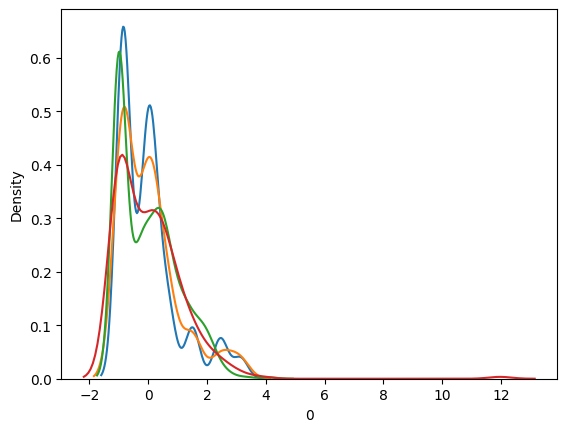

In [14]:
for col in [0,8]:
    sns.kdeplot(X_train_transformed[col],legend = True)
    sns.kdeplot(X_validation_transformed[col],legend = True)

## Model Evaluation

In [111]:
# Let's first take a look how it perform predicting training data
# First start off with root mean squared error
from sklearn.metrics import root_mean_squared_error
y_prediction_training = np.maximum(0,model.predict(X_train_transformed))
print(f'Training data prediction RMSE: {root_mean_squared_log_error(y_prediction_training, y_train)}')

Training data prediction RMSE: 0.1025553148527937


In [112]:
# It looks good with predicting the training data
# Now let's take a look at how it perform with the validation test data
y_prediction_validation =np.maximum(0,model.predict(X_validation_transformed)) 
print(f'Training data prediction RMSE: {root_mean_squared_log_error(y_prediction_validation, y_validation)}')

Training data prediction RMSE: 3.4612447744379593


In [17]:
# Do iteration here if MAE looks bad

In [18]:
# The model is good at predicting training data, however perform poorly when predicting validation data
# This suggest model is overfit
# Hence L2 regularization is introduced:
from sklearn.linear_model import Ridge

model_ridge = Ridge()
model_ridge.fit(X_train_transformed,y_train)
print(f'Ridge regression model has trained successfully')

Ridge regression model has trained successfully


In [114]:
# Let's see how well it can predict using training data
y_prediction_training_ridge = np.maximum(0, model_ridge.predict(X_train_transformed))
print(f'Ridge=> Training data prediction RMSE: {root_mean_squared_log_error(y_prediction_training_ridge, y_train)}')

Ridge=> Training data prediction RMSE: 0.37969049613297157


In [115]:
# Training data is still performing well with ridge, let's test with validation data
y_prediction_validation_ridge = np.maximum(0, model_ridge.predict(X_validation_transformed))
print(f'Ridge=> Validation data prediction RMSE: {root_mean_squared_log_error(y_prediction_validation_ridge, y_validation)}')

Ridge=> Validation data prediction RMSE: 0.3666014377254288


In [117]:
# ALOT better compare to the previous linear regression model
# Now let's see how it looks with log value
from sklearn.metrics import root_mean_squared_log_error
print(f'Ridge=> Training data prediction RMSE_log: {root_mean_squared_error(y_prediction_training_ridge, y_train)}')
print(f'Ridge=> Validation data prediction RMSE_log: {root_mean_squared_error(y_prediction_validation_ridge, y_validation)}')
print(f'Ridge=> Training data prediction sqrt RMSE_log: {np.sqrt(root_mean_squared_log_error(y_prediction_training_ridge, y_train))}')
print(f'Ridge=> Validation data prediction sqrt RMSE_log: {np.sqrt(root_mean_squared_log_error(y_prediction_validation_ridge, y_validation))}')

Ridge=> Training data prediction RMSE_log: 73006.49331143165
Ridge=> Validation data prediction RMSE_log: 77793.80446936062
Ridge=> Training data prediction sqrt RMSE_log: 0.6161903083731288
Ridge=> Validation data prediction sqrt RMSE_log: 0.6054762073982997


In [87]:
# Increase the alpha, and check again the results
model_ridge.alpha = 15
model_ridge.fit(X_train_transformed,y_train)
print(f'Ridge regression model has trained successfully')

Ridge regression model has trained successfully


In [88]:
y_prediction_training_ridge = model_ridge.predict(X_train_transformed)
y_prediction_validation_ridge = model_ridge.predict(X_validation_transformed)
print(f'Ridge=> Training data prediction RMSE_log: {root_mean_squared_log_error(y_prediction_training_ridge, y_train)}')
print(f'Ridge=> Validation data prediction RMSE_log: {root_mean_squared_log_error(y_prediction_validation_ridge, y_validation)}')

Ridge=> Training data prediction RMSE_log: 0.11443863446522018
Ridge=> Validation data prediction RMSE_log: 0.16752280016675108


In [147]:
# Find optimal alpha value

# Ranges of alpha value, 10e-5 -> 10e5
alpha_values = np.logspace(-3, 3)

# Empty list to contain the respective training and validation results
train_rmse_log = []
validation_rmse_log = []
alpha_training_tuple = []
alpha_validation_tuple = []

# Iterate each alpha value
for alpha_val in alpha_values:
    model_ridge.alpha = alpha_val
    model_ridge.fit(X_train_transformed,y_train)
    y_prediction_training_ridge = np.maximum(0, model_ridge.predict(X_train_transformed))
    y_prediction_validation_ridge = np.maximum(0, model_ridge.predict(X_validation_transformed))
    print(f'Alpha {alpha_val}')
    print(f'Ridge=> Training data prediction RMSE_log: {root_mean_squared_log_error(y_prediction_training_ridge, y_train)}')
    print(f'Ridge=> Validation data prediction RMSE_log: {root_mean_squared_log_error(y_prediction_validation_ridge, y_validation)}')
    alpha_training_tuple.append((alpha_val, root_mean_squared_log_error(y_prediction_training_ridge, y_train)))
    alpha_validation_tuple.append((alpha_val, root_mean_squared_log_error(y_prediction_validation_ridge, y_validation)))

min_training_dev = min(alpha_training_tuple, key = lambda t:t[1])
print(min_training_dev)

min_validation_dev = min(alpha_validation_tuple, key = lambda t:t[1])
print(min_validation_dev)

Alpha 0.001
Ridge=> Training data prediction RMSE_log: 0.10258713296906814
Ridge=> Validation data prediction RMSE_log: 1.0214143038957497
Alpha 0.0013257113655901094
Ridge=> Training data prediction RMSE_log: 0.10258341189285232
Ridge=> Validation data prediction RMSE_log: 1.0214125239128866
Alpha 0.0017575106248547913
Ridge=> Training data prediction RMSE_log: 0.10257851669968827
Ridge=> Validation data prediction RMSE_log: 1.0214101076100333
Alpha 0.002329951810515372
Ridge=> Training data prediction RMSE_log: 0.1025720930975762
Ridge=> Validation data prediction RMSE_log: 1.021406806149249
Alpha 0.0030888435964774815
Ridge=> Training data prediction RMSE_log: 0.10256369197691204
Ridge=> Validation data prediction RMSE_log: 1.021402259782575
Alpha 0.004094915062380427
Ridge=> Training data prediction RMSE_log: 0.10255275318252043
Ridge=> Validation data prediction RMSE_log: 1.0213959411992073
Alpha 0.005428675439323859
Ridge=> Training data prediction RMSE_log: 0.1025385939339485
Ri

In [148]:
#  Based on the previous result, will be using alpha 19 as input for new model
model_ridge.alpha = 19

In [149]:
# Import test data here
test_data = pd.read_csv(r'C:\Users\user\Documents\GitRepository\HousePrices-AdvancedRegressionTechniques\Received\test.csv',index_col=0)
pd.set_option('display.max_columns',None)
test_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml


In [150]:
# In this test data shouldn't include label value, let's check
has_label = 'SalePrice' in test_data.columns
print(f'Found label in test data => {has_label}')

Found label in test data => False


In [151]:
# Now we can proceed to transform the test data, such that we can predict the test data with our trained model
# Write down the ID of test data before transforming:
X_test_id = test_data.index
X_test_transformed = final_pipeline.transform(test_data)
X_test_transformed.index = X_test_id
print(f'Successfully transformed test data')
X_test_transformed

Dropping column Index([], dtype='int64')
Successfully transformed test data


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,-0.868365,0.500563,0.096483,-0.794852,0.382672,-0.325402,-1.145914,-0.568178,0.064632,0.630290,-0.681439,-0.416395,-0.710050,-0.802555,-0.125918,-1.212823,-0.820747,-0.236888,-1.037179,-0.773624,-1.100873,-0.203898,-0.951178,-0.955603,-0.707095,-1.057111,1.224572,0.357556,-0.700461,-0.364703,-0.115333,1.953670,-0.058085,-0.092588,-0.110602,1.632958,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1462,-0.868365,0.548759,0.343688,-0.063262,0.382672,-0.424104,-1.291011,0.024812,1.110800,-0.291823,-0.370499,0.668828,0.450325,-0.802555,-0.125918,-0.369723,-0.820747,-0.236888,-1.037179,1.238832,0.146285,-0.203898,-0.335338,-0.955603,-0.830853,-1.057111,-0.772060,2.345651,-0.175602,-0.364703,-0.115333,-0.269109,-0.058085,22.628696,-0.110602,1.632958,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1463,0.080530,0.21

In [152]:
# Now we predict the SalePrice with the transformed test data
test_data_sale_price = model_ridge.predict(X_test_transformed)

# Create new dataframe based on this
final_output = {'Id':X_test_transformed.index, 'SalePrice':test_data_sale_price}
test_result_df = pd.DataFrame(final_output)

test_result_df

,Id,SalePrice
0,1461,120188.853904
1,1462,164587.735423
2,1463,190750.678525
3,1464,208518.467783
4,1465,183329.339636
...,...,...
1454,2915,73368.018112
1455,2916,86466.691460
1456,2917,193198.929600
1457,2918,112714.746934


In [153]:
# Write the final prediction result to csv
test_result_df.to_csv(path_or_buf=r'C:\Users\user\Documents\GitRepository\HousePrices-AdvancedRegressionTechniques\Output\house_price_prediction.csv', index = False)